# Combined plots - vector and scalar map
## Victoria, adapted Tobia

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

# Warnings
import warnings
warnings.filterwarnings("ignore", r"\s*The on_mappable_changed")
warnings.filterwarnings("ignore", r"\s*The input coordinates")
warnings.filterwarnings("ignore", r"\s*shading=")
warnings.filterwarnings("ignore", r"\s*\[Warning by")
warnings.filterwarnings("ignore", r"\s*ShapelyDeprecationWarning")

# Load modules
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import cartopy.feature as cf                                                                                                        
from pathlib import Path
import psyplot.project as psy
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
from IPython.display import display, Video
import sys
import datetime as dt
from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray
from ipympl.backend_nbagg import Canvas
Canvas.header_visible.default_value = False

# #own scripts
sys.path.append('../utilities_tlezuo/')
from timefunctions import *
import varfunctions as vf
import locfunctions as lf

# show figures after they are drawn or updated
psy.rcParams['auto_show'] = True
%matplotlib inline
%config InlineBackend.close_figures = False
from psy_simple.plotters import CMap, Bounds
from psy_maps.plotters import Transform, MapPlot2D, LonLatBox, MapPlotter
from psyplot.plotter import Plotter
import psy_simple.plotters
import psy_maps.plotters
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

INFO:numexpr.utils:Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
plotdate = dt.datetime(2019,9,13,8,30)
simdate = dt.datetime(2019,9,12,12,00)
lt = get_lt(plotdate,simdate)
print(str(lt))
lfff_name =lfff_name(lt)


20.5


In [8]:
iconvis.get_example_data()
f_icon      = '../data/example_data/grib/lfff00000000_uv'
gridfile = '../data/example_data/grids/opr_r19b08'

# RUN 5, p levels
filename = 'lfffp'+lfff_name[4:]
f_icon_5 = '/store/s83/tlezuo/RUN5_extended/out_p/'+filename

# RUN 2, reference
filename = lfff_name
f_icon_2 = '/store/s83/tlezuo/RUN2_reference/out_std/'+filename


 
Getting data from folder: grib
 
Getting data from folder: grids
 
Getting data from folder: nc
 
Getting data from folder: pyvis


In [9]:
f_icon_2

'/store/s83/tlezuo/RUN2_reference/out_std/lfff00203000.nc'

In [4]:

# If necessary, add the corresponding grid file:
gridfile = '../data/example_data/grids/ICON-1E_DOM01.nc'
# gridfile = '/scratch/e1000/meteoswiss/scratch/tlezuo/sandbox_tlezuo/inp/grid_R19B08_size_cosmo1/d01_DOM01.nc'
# gridfile = '/scratch/e1000/meteoswiss/scratch/tlezuo/sandbox_tlezuo/RUN5_extended/out_5_ext/vgrid_DOM01.nc'


In [5]:

if iconvis.check_grid_information(f_icon):
    print('The grid information is available')
    data = psy.open_dataset(f_icon)
else:
    print('The grid information is not available')
    data = iconvis.combine_grid_information(f_icon,gridfile)

print(filename)

The grid information is available
lfffp00203000.nc


### Remap ICON wind data to Regular grid for plotting

ICON data can be too dense to plot wind barbs nicely, so to reduce the density of barbs, we can first interpolate the data to regular grid.

#### Fieldextra interpolation

In [6]:
output_file = iconvis.remap_ICON_to_regulargrid(
                                        data_file=f_icon,
                                        in_grid_file=gridfile,
                                        num_dates=data.time.shape[0], # number of time steps in your data.
                                        region='ch' # 'switzerland'/'ch' or 'europe'
                                    )

Creating regular grid over Switzerland region.

Fieldextra Namelist saved to:/users/tlezuo/icon-vis/combinedplot/tmp/fieldextra/NAMELIST_ICON_REG_REMAP

Running fieldextra:/project/s83c/fieldextra/tsa/bin/fieldextra_gnu_opt_omp /users/tlezuo/icon-vis/combinedplot/tmp/fieldextra/NAMELIST_ICON_REG_REMAP

SQ %INFO fieldextra: Exception detected in program


Exception: Fieldextra did not run successfully, check the LOG: /users/tlezuo/icon-vis/combinedplot/tmp/fieldextra/LOG_ICON_REG_REMAP.txt

In [ ]:
print(output_file)

ds_interp = psy.open_dataset(output_file)
ds_interp

/users/tlezuo/icon-vis/combinedplot/tmp/fieldextra/lfff00000000_uv_interpolated_regulargrid.nc


<xarray.Dataset>
Dimensions:         (time: 1, x_1: 101, y_1: 101, z_1: 80, zbound: 2, epsd_1: 1)
Coordinates:
  * time            (time) datetime64[ns] 2021-06-20T12:00:00
  * x_1             (x_1) float32 5.5 5.555 5.61 5.665 ... 10.89 10.94 11.0
  * y_1             (y_1) float32 45.5 45.53 45.55 45.58 ... 47.95 47.97 48.0
    lon_1           (y_1, x_1) float32 ...
    lat_1           (y_1, x_1) float32 ...
    grid_mapping_1  |S1 ...
  * z_1             (z_1) float32 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
    z_bnds_1        (z_1, zbound) float32 ...
  * epsd_1          (epsd_1) int32 1
Dimensions without coordinates: zbound
Data variables:
    U               (time, epsd_1, z_1, y_1, x_1) float32 ...
    V               (time, epsd_1, z_1, y_1, x_1) float32 ...
Attributes:
    Conventions:     CF-1.6
    ConventionsURL:  http://cfconventions.org/cf-conventions/v1.6.0/cf-conven...
    institution:     MeteoSwiss (NMC Switzerland)
    source:          model: icon-ch1-eps, production_status: test_operational...
    history:         Produced by fieldextra version v14.1.0d (dev_test_passed...

In [ ]:
ds_interp.U.encoding['coordinates'] = 'x_1 y_1'
ds_interp.V.encoding['coordinates'] = 'x_1 y_1'

#### Note
The remap_ICON_to_regulargrid module has only been tested/written for netcdf, with U,V variables, and creating a regular grid region over Switzerland). If the namelist generation doesnt work for your data, you can alternatively modify the NAMELIST_ICON_REG_REMAP file and run fieldextra yourself. For example on Tsa, in your shell you can run:

`/project/s83c/fieldextra/tsa/bin/fieldextra_gnu_opt_omp NAMELIST_ICON_REG_REMAP` 

You can define the output location and use that as input to psyplot, as in next step.

In [ ]:
import psyplot.data as psyd

uv = ds_interp.psy.create_list(name=[["U", "V"]], time=0, z=79, squeeze=True)[0] # regular grid wind data
temp = ds.psy.create_list(name="t", t=0, z=79)[0]  # icon grid temperature data


In [ ]:
data = psyd.InteractiveList([temp, uv])

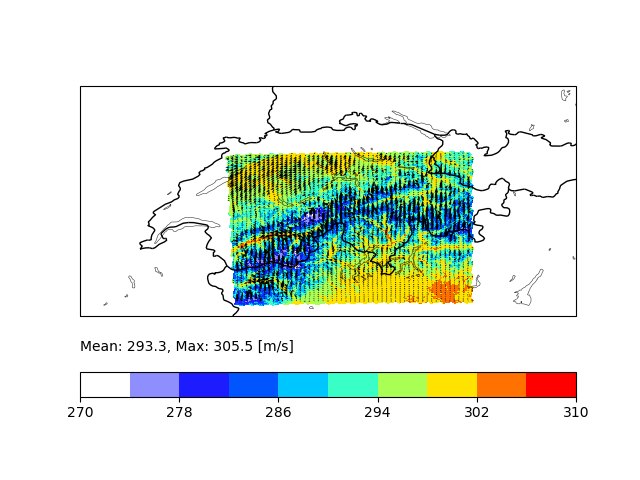

In [ ]:
plotter = psy.plot.mapcombined.plotter_cls(data)

In [ ]:
from psyplot.project import Project
project = Project([data])

In [ ]:
project.update(
    borders=True,
    cmap='Reds',
    density=0.4, 
    arrowsize=200,
    map_extent=[6.9, 10.2, 45.3, 47.5],
   vplot='quiver',
clabel='{desc}',
title='Combined Scalar and Vector Plot after Interpolation')
# projcet.show()

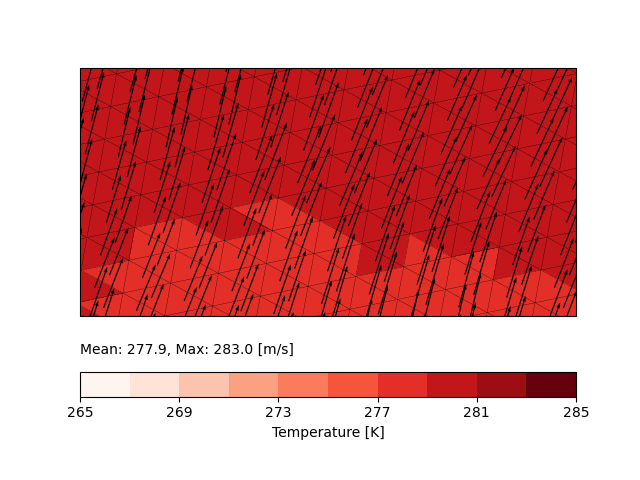

In [ ]:
plt.ioff()

with project as sp:
    sp.export('combined_plot.png')

plt.ion()
plt.show()